In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import keras, tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LSTM
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split


In [2]:
def extract(img, smaller):
        
    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    if(smaller):
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

        # Applying dilation on the threshold image
        dilation = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, rect_kernel, iterations = 1)
        # dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    else:
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

        # Applying dilation on the threshold image
        dilation = cv2.dilate(thresh1, rect_kernel, iterations = 2)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                    cv2.CHAIN_APPROX_NONE)

    return contours

In [40]:
def boundingbox(img_path, model):
    img = cv2.imread(img_path)
    contours = extract(img, False)

    sum = 0
    y_pred = []
    boxes = []
    im = img.copy()
    crops = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (255, 0, 0), 2)
            
        # Cropping the text block
        cropped = img[y:y + h, x:x + w]

        # extract each alphabet from each block
        contours2 = extract(cropped, True)
        
        for i in contours2:
            # count alphabets 
            sum += 1

            x2, y2, w2, h2 = cv2.boundingRect(i)
            
            cropped2 = img[y+y2: y+y2+h2, x+x2: x+x2+w2]
            
            center_x = (x + x2 + w2 / 2) / img.shape[1]
            center_y = (y + y2 + h2 / 2) / img.shape[0]
            normalized_width = w2 / img.shape[1]
            normalized_height = h2 / img.shape[0]

            # Append the YOLO format coordinates to the boxes list
            boxes.append([center_x, center_y, normalized_width, normalized_height])


            # boxes.append([x+x2, y+y2, x+x2 + w2, y+y2 + h2]) 

            cropped2 = cv2.resize(cropped2, (64,64))
            
            crops.append(cropped2)

            cropped2 = cropped2.reshape((1, 64, 64, 3))

            y_pred.append(model.predict(cropped2))

    
    order = np.argsort([x[0] for x in boxes])
    boxes = [boxes[x] for x in order]
    crops = [crops[x] for x in order]
    # y_pred = [y_pred[x] for x in order]
    
    # y_pred = np.array(y_pred)
    return sum, boxes, im, crops
    # return sum, y_pred, boxes, im, crops


In [23]:
def read(base_directory):
    # Initialize empty lists to store image data and corresponding labels
    img_data = []
    labels = []
    num_files_per_class = 160

    # Iterate through each alphabet folder in the train directory
    for alphabet_folder in os.listdir(os.path.join(base_directory, 'train')):
        alphabet_path = os.path.join(base_directory, 'train', alphabet_folder)
        
        file_counter = 0

        # Iterate through each image file in the alphabet folder
        for image_file_name in os.listdir(alphabet_path):
            image_path = os.path.join(alphabet_path, image_file_name)
            
            try:
                # Read the image using cv2.imread
                img = cv2.imread(image_path)

                # Convert the image from BGR to RGB (cv2.imread reads in BGR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, (64, 64))
                
                # Append the image array and corresponding label to the lists
                img_data.append(img)
                labels.append(alphabet_folder)

                # Increment the file counter
                file_counter += 1

                # Check if the desired number of files per class is reached
                if num_files_per_class is not None and file_counter >= num_files_per_class:
                    break

            except Exception as e:
                # Handle any potential errors, such as corrupted images
                print(f"Error processing {image_path}: {e}")
    return img_data, labels

# Specify the directory containing your image files
uppercase_directory = os.path.join(os.getcwd(), 'dataset')
lowercase_directory = os.path.join(os.getcwd(), 'datasetSmall')
digit_directory = os.path.join(os.getcwd(), 'datasetDigit')

# Read images for each dataset
uppercase_data, uppercase_labels = read(uppercase_directory)
lowercase_data, lowercase_labels = read(lowercase_directory)
digit_data, digit_labels = read(digit_directory)

# Combine the datasets into a single NumPy array
train_data_temp = np.concatenate((uppercase_data, lowercase_data, digit_data), axis=0)
train_labels_temp = np.concatenate((uppercase_labels, lowercase_labels, digit_labels), axis=0)

# Create a DataFrame for easier manipulation
model_training_df = pd.DataFrame({'data': train_data_temp.tolist(), 'labels': train_labels_temp})
class_names = model_training_df.labels.unique()

# split each class equaly
x_train, y_train, x_test, y_test = [], [], [], []
temp = []
for name in class_names:
    split = model_training_df[model_training_df.labels == name]
    X = split['data']
    Y = split['labels']
    Y = [np.where(class_names == label)[0] for label in Y]

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.8)

    x_train.extend(X_train)
    y_train.extend(Y_train)
    x_test.extend(X_test)
    y_test.extend(Y_test)


# shuffle order of train and test data
temp_x_train, temp_y_train, temp_x_test, temp_y_test = [], [], [], []

train_rand_order = np.arange(len(x_train))
test_rand_order = np.arange(len(x_test))
np.random.shuffle(train_rand_order)
np.random.shuffle(test_rand_order)
for i in train_rand_order:
    temp_x_train.append(x_train[i])
    temp_y_train.append(y_train[i])

for j in test_rand_order:
    temp_x_test.append(x_test[j])
    temp_y_test.append(y_test[j])    

x_train = np.array(temp_x_train, dtype=np.float32)
x_test = np.array(temp_x_test, dtype=np.float32)
y_train = np.array(temp_y_train)
y_test = np.array(temp_y_test)


# one-hot-encoded the label
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

In [685]:
# each classes(62 classes) has 55 images 
model_training_csv = os.path.join(os.getcwd(), 'alphabets/english.csv')
model_image_training = os.path.join(os.getcwd(), 'alphabets')

# make dataframe for training model 
model_training_df = pd.read_csv(model_training_csv)
# add columns of image
model_training_df['img'] = ''
# get image for each image name
for i in range(len(model_training_df)):
    img_path = os.path.join(model_image_training, model_training_df.at[i, 'image'])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))

    model_training_df.at[i, 'img'] = img
# get all class names
class_names = model_training_df.label.unique()

# split each class equaly
x_train, y_train, x_test, y_test = [], [], [], []
temp = []
for name in class_names:
    split = model_training_df[model_training_df.label == name]
    X = split['img']
    Y = split['label']
    Y = [np.where(class_names == label)[0] for label in Y]

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.8)

    x_train.extend(X_train)
    y_train.extend(Y_train)
    x_test.extend(X_test)
    y_test.extend(Y_test)


# shuffle order of train and test data
temp_x_train, temp_y_train, temp_x_test, temp_y_test = [], [], [], []

train_rand_order = np.arange(len(x_train))
test_rand_order = np.arange(len(x_test))
np.random.shuffle(train_rand_order)
np.random.shuffle(test_rand_order)
for i in train_rand_order:
    temp_x_train.append(x_train[i])
    temp_y_train.append(y_train[i])

for j in test_rand_order:
    temp_x_test.append(x_test[j])
    temp_y_test.append(y_test[j])    

x_train = np.array(temp_x_train, dtype=np.float32)
x_test = np.array(temp_x_test, dtype=np.float32)
y_train = np.array(temp_y_train)
y_test = np.array(temp_y_test)


# one-hot-encoded the label
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

In [24]:
datagen = ImageDataGenerator(
    shear_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.2, 0.2],
)

datagen.fit(x_train)


In [34]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))  # Adding dropout
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))  # Adding dropout
model.add(Dense(62, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                

In [35]:
batch_size = 32

# initiate RMSprop optimizer
# Using M1 mac
# opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0005)
opt = keras.optimizers.legacy.Adam(learning_rate=0.0005)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

# history_1 = model.fit(x_train, y_train,
#                         batch_size=batch_size,
#                         epochs=10,
#                         validation_data=(x_test, y_test),
#                         shuffle=True)
history_1 = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)


Epoch 1/10
248/248 [==============================] - 25s 100ms/step - loss: 4.1284 - accuracy: 0.0205 - val_loss: 4.1390 - val_accuracy: 0.0197
Epoch 2/10
248/248 [==============================] - 26s 105ms/step - loss: 4.0243 - accuracy: 0.0394 - val_loss: 5.0125 - val_accuracy: 0.0161
Epoch 3/10
248/248 [==============================] - 27s 110ms/step - loss: 3.8906 - accuracy: 0.0533 - val_loss: 6.1445 - val_accuracy: 0.0302
Epoch 4/10
248/248 [==============================] - 28s 114ms/step - loss: 3.7921 - accuracy: 0.0712 - val_loss: 9.8507 - val_accuracy: 0.0096
Epoch 5/10
248/248 [==============================] - 29s 117ms/step - loss: 3.7096 - accuracy: 0.0720 - val_loss: 6.3310 - val_accuracy: 0.0348
Epoch 6/10
248/248 [==============================] - 29s 118ms/step - loss: 3.6477 - accuracy: 0.0872 - val_loss: 9.4719 - val_accuracy: 0.0318
Epoch 7/10
248/248 [==============================] - 30s 119ms/step - loss: 3.5934 - accuracy: 0.0880 - val_loss: 9.0684 - val_ac

In [691]:
train_img_path = os.path.join(os.getcwd(), "archive/train_v2/train")
test_img_path = os.path.join(os.getcwd(), "archive/test_v2/test")

train_csv_path = os.path.join(os.getcwd(), "archive/written_name_train_v2.csv")
test_csv_path = os.path.join(os.getcwd(), "archive/written_name_test_v2.csv")



df = pd.read_csv(test_csv_path)
cnt = 0
im = 0
boxes = []

# for i in range (df.shape[0]):
for i in range (37867,37868):
    print(df['FILENAME'][i])
    img_name = os.path.join(test_img_path, df['FILENAME'][i])
    num_of_char, boxes, img, crop = boundingbox(img_name, model)
    # num_of_char, y_pred, boxes, img, crop = boundingbox(img_name, model)
    
    if num_of_char == len(str(df['IDENTITY'][i])):
        cnt += 1
    im = img
    # cnt = num_of_char

TEST_37868.jpg
1/1 [==============================] - 0s 11ms/step


In [692]:
word = ''
for i in y_pred:
    m = np.argmax(i)
    word += class_names[m]
print(word)
print(boxes)

iiiv
[[12, 14, 20, 28], [30, 14, 37, 26], [46, 15, 55, 28], [65, 14, 71, 28]]


In [36]:
ans = 'StandardRNNshavepoormemory'
num_of_char, y_pred, boxes, img, crop = boundingbox(os.path.join(os.getcwd(), "com_text3.png"), model)
print(num_of_char)
word = ''
for i in y_pred:
    m = np.argmax(i)
    word += class_names[m]
print(word)


1/1 [==============================] - 0s 11ms/step
26
BCBDBBCBDmBBDAWBABACWBWACA


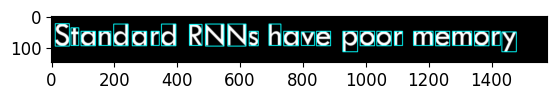

In [379]:
# save resulting image
for x1, y1, x2, y2 in boxes:
    rect = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(cv2.bitwise_not(img))
# plt.imshow(crop[1])

In [37]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 14.028097, Accuracy: 0.016129
 Test Loss: 14.043509, Accuracy: 0.017137

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


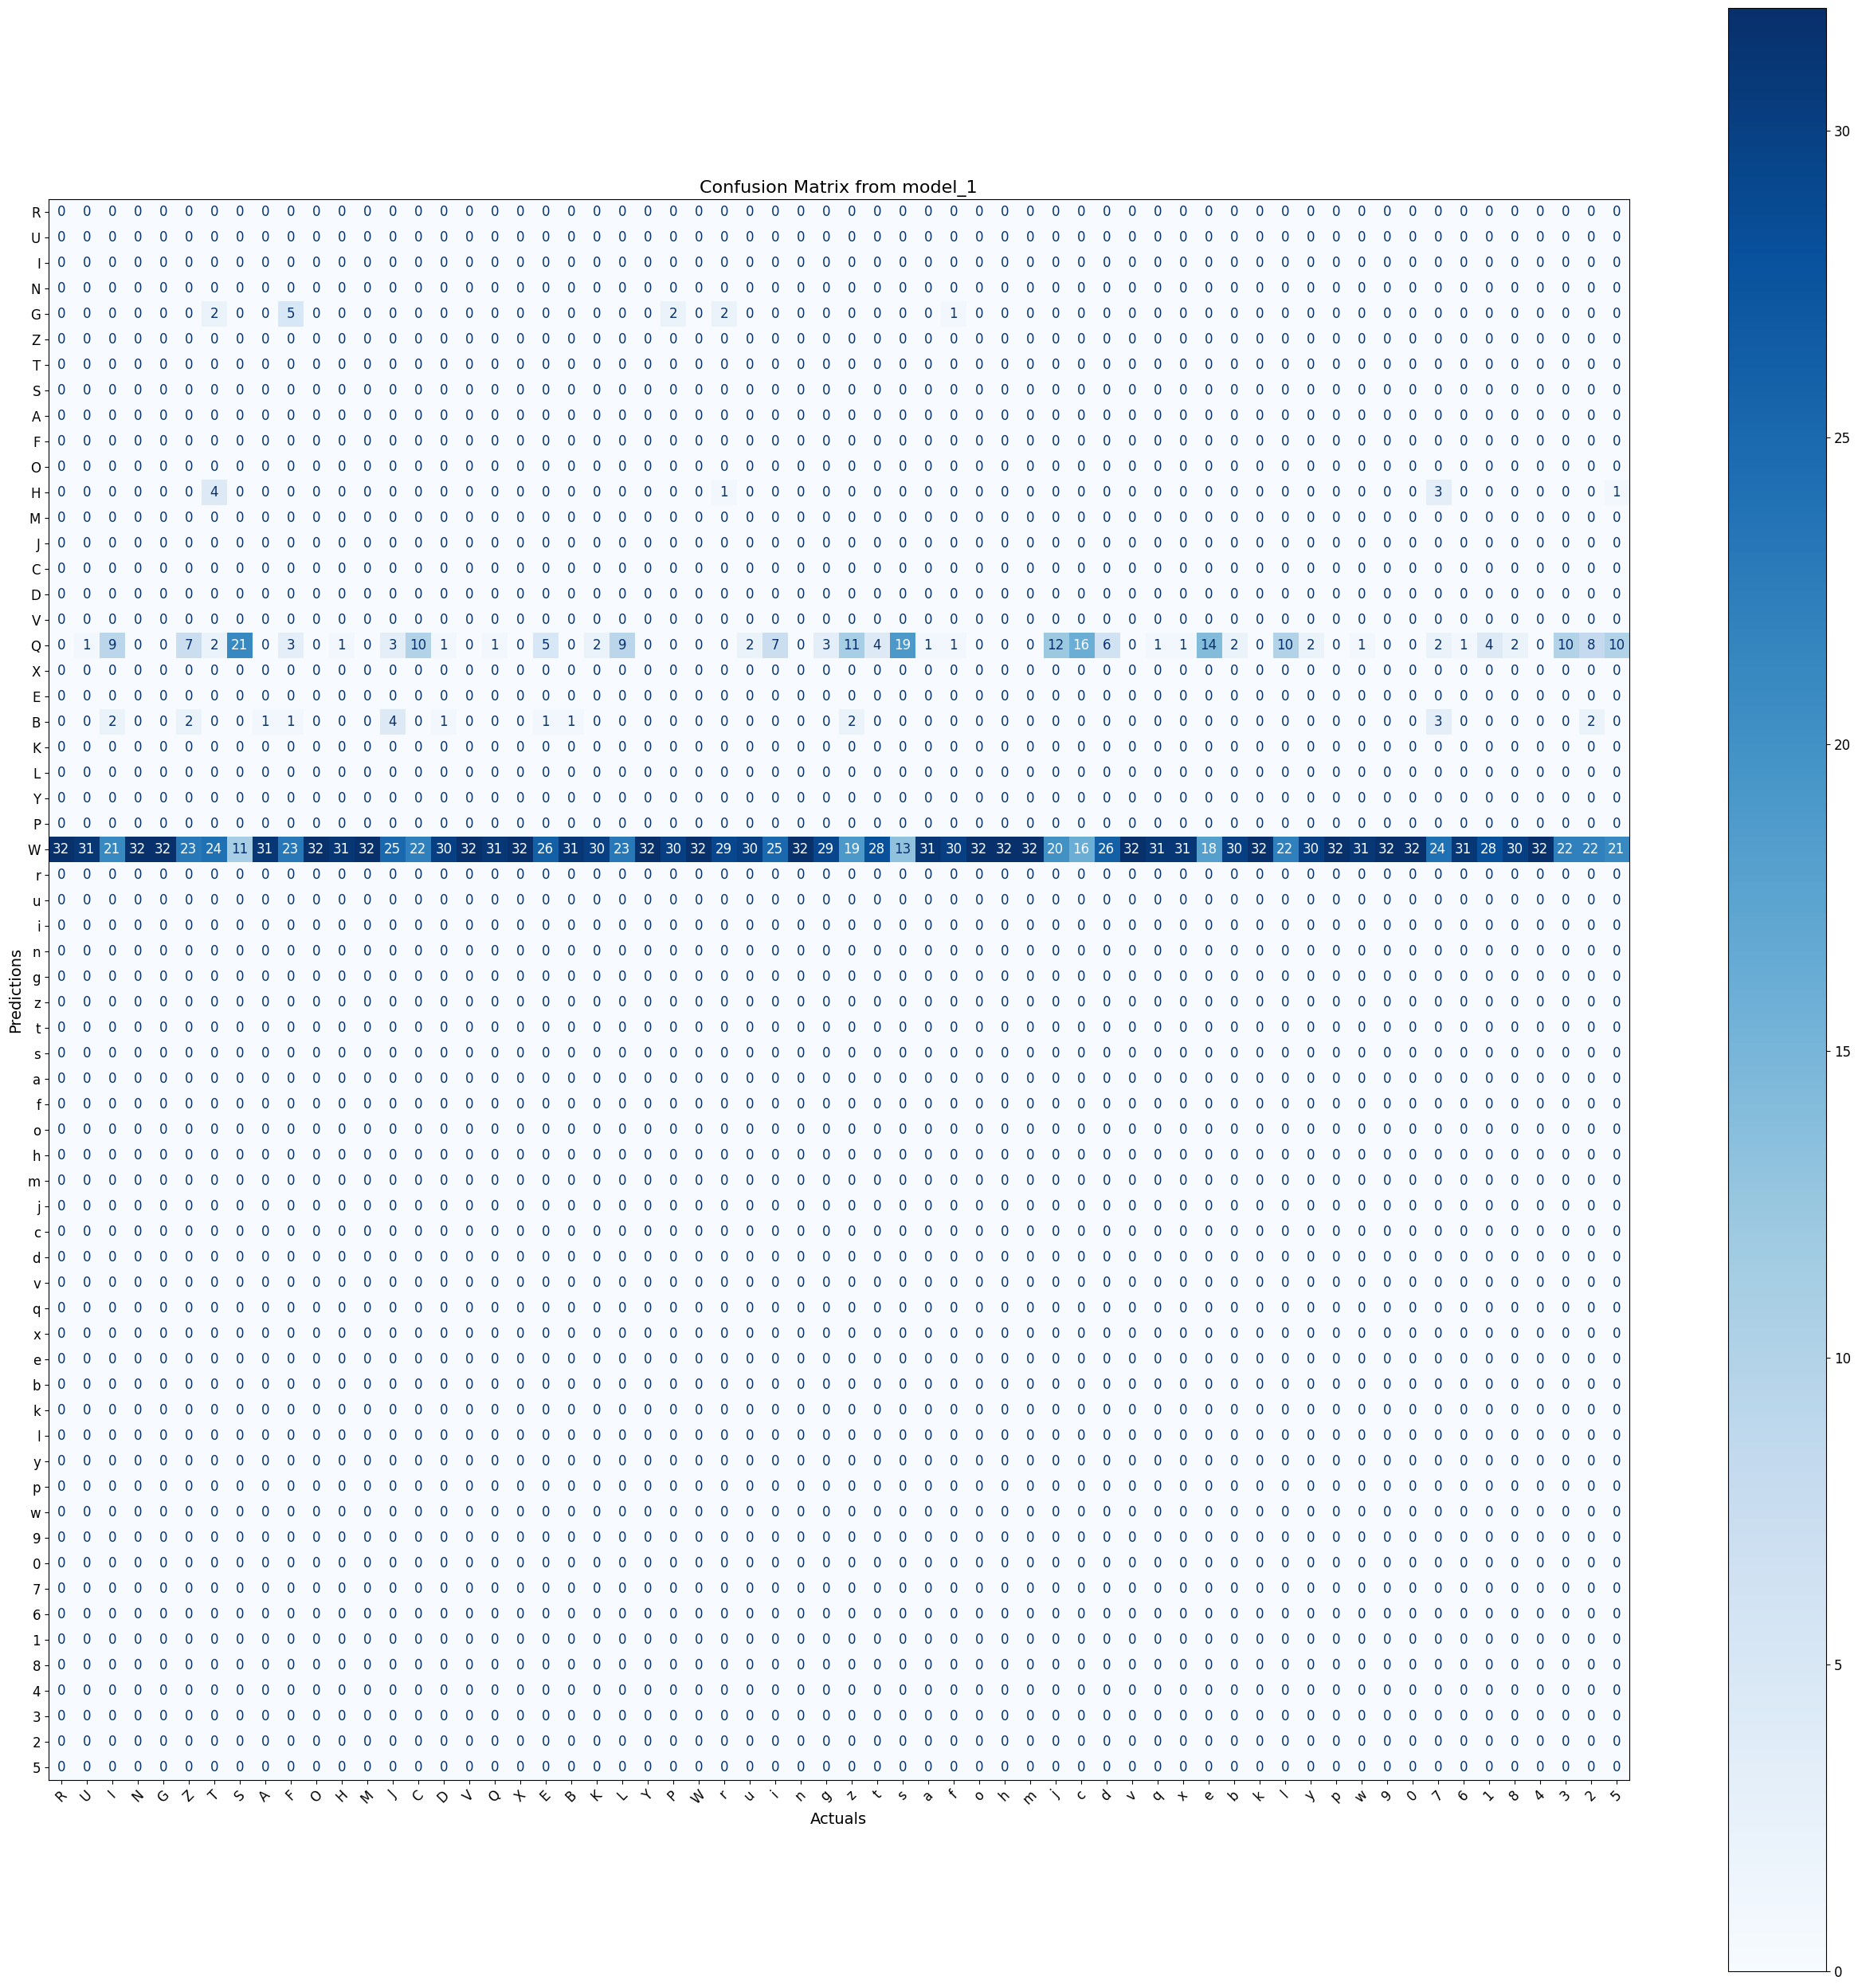

In [38]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(32, 32))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [39]:
np.set_printoptions(precision=2)
# classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names)
print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

           R       0.00      0.00      0.00        32
           U       0.00      0.00      0.00        32
           I       0.00      0.00      0.00        32
           N       0.00      0.00      0.00        32
           G       0.00      0.00      0.00        32
           Z       0.00      0.00      0.00        32
           T       0.00      0.00      0.00        32
           S       0.00      0.00      0.00        32
           A       0.00      0.00      0.00        32
           F       0.00      0.00      0.00        32
           O       0.00      0.00      0.00        32
           H       0.00      0.00      0.00        32
           M       0.00      0.00      0.00        32
           J       0.00      0.00      0.00        32
           C       0.00      0.00      0.00        32
           D       0.00      0.00      0.00        32
           V       0.00      0.00      0.00        32
           Q       0.00    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.